# Average performance of sparse coders
## Synthetic data
## Random missing entries

In [21]:
"""
Script that compares the performance of sparse coding variants considered
in "RobOMP: Robust variants of Orthogonal Matching Pursuit for sparse 
representations" DOI: 10.7717/peerj-cs.192 (open access)
Missing entries noise (fixed K)
Author: Carlos Loza
https://github.carlosloza/RobOMP

Methodology:
------------
1. A dictionary (D) with atoms from a random density (Normal) are generated
2. Samples that are sparsely encoded by D are generated (ground truth 
sparsity level is provided)
3. Additive zero-mean gaussian noise is added to samples
4. The following sparse coders are implemented:
  - Orthogonal Matching Pursuit (OMP)
  - Generalized OMP (with optional set of number of atoms per run)
  - Correntropy Matching Pursuit
  - Robust m-estimator-based variants of OMP: Fair, Cauchy, Huber, Tukey,
    Welsh
5. Performance measure: Average normalized L2-norm of difference between 
ground truth sparse code and estimated sparse code

Notes:
------
- Sparsity level of sparse coders is set equal to ground truth
- Several missing entries rates and number of iterations are allowed
- Execution time is tracked as well
- This script replicates the results summarized in Fig 2 of RobOMP article
- The results in the article took a random seed so the final outputs
of this script might not exactly match the published results
- Lastly, this new version implements a warm start of RobOMP by default,
i.e. the Huber solution is the initial solution for every RobOMP case
Empirically, this initialization was not only proved to be more stable,
but it also yielded better performance

CORRECTION: The original results in Fig 2 for gOMP overestimated the
sparsity level, therefore, the normalized norm was larger than the (right)
results obtained via this script
"""

# Import packages (RobOMP is one directory up assuming directories as in remote repo)
import sys
sys.path.insert(1, '../')
from RobOMP import gOMP, CMP, RobustOMP
import numpy as np
import time
import matplotlib.pyplot as plt

In [22]:
# Parameters
# Dimensionality and number of atoms
m, n = 100, 500
# Ground truth sparsity level
K = 10
# Set of rates of missing entries
zeroentries_v = np.arange(0.05, 0.505, 0.05)
nzent = zeroentries_v.size
# Set of number of atoms extracted per iteration by gOMP
N0_v = np.array([5, 10, 20])
# For reproducibility
np.random.seed(34)
# Number of iterations
n_it = 100

In [23]:
# Initialize error and time arrays
err_OMP = np.zeros((nzent, n_it))
err_gOMP = np.zeros((nzent, n_it, N0_v.size))
err_CMP = np.zeros((nzent, n_it))
err_CauchyOMP = np.zeros((nzent, n_it))
err_FairOMP = np.zeros((nzent, n_it))
err_HuberOMP = np.zeros((nzent, n_it))
err_TukeyOMP = np.zeros((nzent, n_it))
err_WelschOMP = np.zeros((nzent, n_it))

time_OMP = np.zeros((nzent, n_it))
time_gOMP = np.zeros((nzent, n_it, N0_v.size))
time_CMP = np.zeros((nzent, n_it))
time_CauchyOMP = np.zeros((nzent, n_it))
time_FairOMP = np.zeros((nzent, n_it))
time_HuberOMP = np.zeros((nzent, n_it))
time_TukeyOMP = np.zeros((nzent, n_it))
time_WelschOMP = np.zeros((nzent, n_it))

In [24]:
print("Ground truth sparsity level: " '{:d}'.format(K))
print("Number of iterations per case: " '{:d}'.format(n_it))
for i in range(0, nzent):
    print("Rate of missing entries: " '{:1.2f}'.format(zeroentries_v[i]))
    for it in range(0, n_it):
        # Synthetic dictionary
        D = np.random.normal(0, 1, (m, n))
        # Normalized atoms
        D = np.divide(D, np.linalg.norm(D, axis=0))
        # Ground truth sparse code
        x0 = np.zeros((n, 1))
        x0[np.random.choice(n, K, replace=False)] = np.random.normal(0, 1, (K, 1))
        y = np.matmul(D, x0)
        # Randomly selected entries are set to zero (missing entries)
        y[np.random.choice(m, int(zeroentries_v[i]*m), replace=False)] = 0;
        
        # OMP
        t = time.time()
        xOMP = gOMP(nnonzero=K, N0=1).fit(D, y).coef_
        time_OMP[i, it] = time.time() - t
        err_OMP[i, it] = np.linalg.norm(x0.flatten() - xOMP)/np.linalg.norm(x0)
        
        # gOMP
        for j in range(N0_v.size):
            t = time.time()
            xgOMP = gOMP(nnonzero=K, N0=N0_v[j]).fit(D, y).coef_
            time_gOMP[i, it, j] = time.time() - t
            err_gOMP[i, it, j] = np.linalg.norm(x0.flatten() - xgOMP)/np.linalg.norm(x0)
        
        # Correntropy Matching Pursuit (CMP)
        t = time.time()
        xCMP = CMP(nnonzero=K).fit(D, y).coef_
        time_CMP[i, it] = time.time() - t
        err_CMP[i, it] = np.linalg.norm(x0.flatten() - xCMP)/np.linalg.norm(x0)
        
        # CauchyOMP
        t = time.time()
        xCauchyOMP = RobustOMP(nnonzero=K, m_est='Cauchy').fit(D, y).coef_
        err_CauchyOMP[i, it] = np.linalg.norm(x0.flatten() - xCauchyOMP)/np.linalg.norm(x0)
        
        # FairOMP
        t = time.time()
        xFairOMP = RobustOMP(nnonzero=K, m_est='Fair').fit(D, y).coef_
        err_FairOMP[i, it] = np.linalg.norm(x0.flatten() - xFairOMP)/np.linalg.norm(x0)
        
        # HuberOMP
        t = time.time()
        xHuberOMP = RobustOMP(nnonzero=K, m_est='Huber').fit(D, y).coef_
        err_HuberOMP[i, it] = np.linalg.norm(x0.flatten() - xHuberOMP)/np.linalg.norm(x0)
        
        # TukeyOMP
        t = time.time()
        xTukeyOMP = RobustOMP(nnonzero=K, m_est='Tukey').fit(D, y).coef_
        err_TukeyOMP[i, it] = np.linalg.norm(x0.flatten() - xTukeyOMP)/np.linalg.norm(x0)
        
        # WelschOMP
        t = time.time()
        xWelschOMP = RobustOMP(nnonzero=K, m_est='Welsch').fit(D, y).coef_
        err_WelschOMP[i, it] = np.linalg.norm(x0.flatten() - xWelschOMP)/np.linalg.norm(x0)
        

Ground truth sparsity level: 10
Number of iterations per case: 100
Rate of missing entries: 0.05
Rate of missing entries: 0.10
Rate of missing entries: 0.15
Rate of missing entries: 0.20
Rate of missing entries: 0.25
Rate of missing entries: 0.30
Rate of missing entries: 0.35
Rate of missing entries: 0.40
Rate of missing entries: 0.45
Rate of missing entries: 0.50


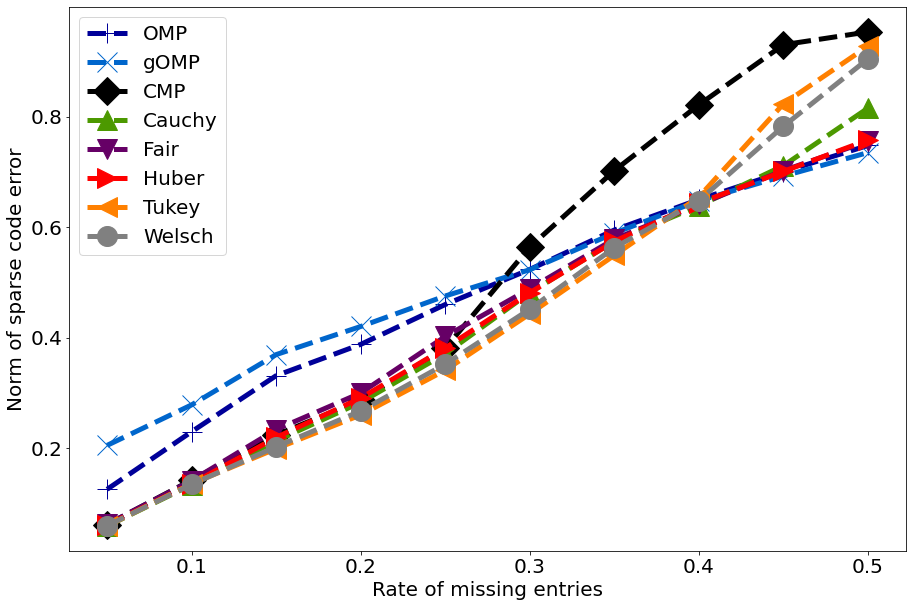

In [29]:
# Plot results
FontSize = 20
FontSizeLegend = 20
LineWidth = 5
MarkerSize = 20
plt.figure(figsize=(15, 10))
plt.rc('font', size=FontSize)
plt.rc('legend', fontsize=FontSizeLegend)
plt.plot(zeroentries_v, np.mean(err_OMP, axis=1), color = (0/255, 0/255, 153/255), linestyle='--', marker="+", linewidth=LineWidth, markersize=MarkerSize)
# Best case for gOMP
idxgOMP = 0
plt.plot(zeroentries_v, np.mean(err_gOMP[:,:,idxgOMP], axis=1), color = (0/255, 102/255, 204/255), linestyle='--', marker="x", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, np.mean(err_CMP, axis=1), color = (0/255, 0/255, 0/255), linestyle='--', marker="D", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, np.mean(err_CauchyOMP, axis=1), color = (76/255, 153/255, 0/255), linestyle='--', marker="^", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, np.mean(err_FairOMP, axis=1), color = (102/255, 0/255, 102/255), linestyle='--', marker="v", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, np.mean(err_HuberOMP, axis=1), color = (255/255, 0/255, 0/255), linestyle='--', marker=">", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, np.mean(err_TukeyOMP, axis=1), color = (255/255, 128/255, 0/255), linestyle='--', marker="<", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, np.mean(err_WelschOMP, axis=1), color = (128/255, 128/255, 128/255), linestyle='--', marker="o", linewidth=LineWidth, markersize=MarkerSize)
plt.ylabel('Norm of sparse code error')
plt.xlabel('Rate of missing entries')
plt.legend(('OMP','gOMP','CMP','Cauchy','Fair','Huber','Tukey','Welsch'))
plt.show()

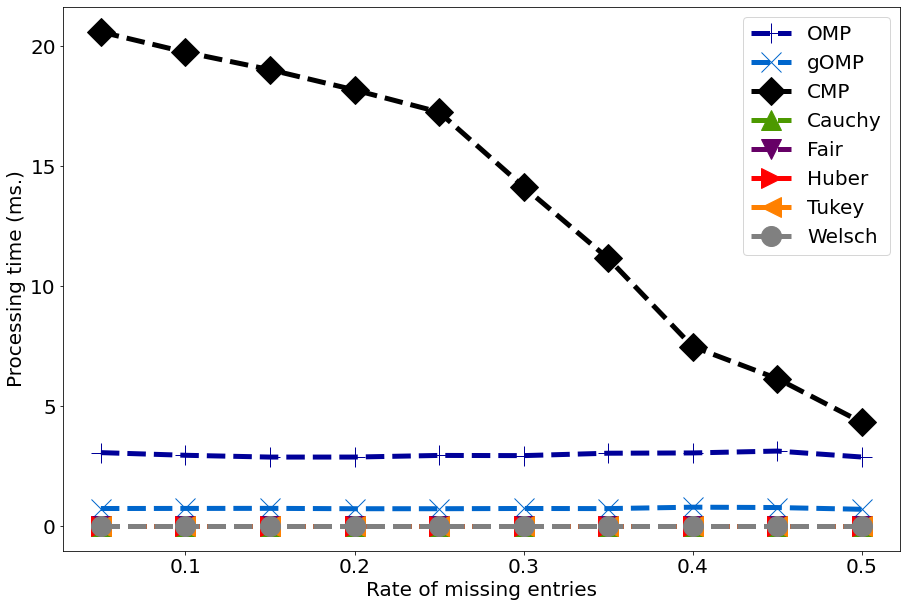

In [30]:
# Plot times in miliseconds
FontSize = 20
FontSizeLegend = 20
LineWidth = 5
MarkerSize = 20
plt.figure(figsize=(15, 10))
plt.rc('font', size=FontSize)
plt.rc('legend', fontsize=FontSizeLegend)
plt.plot(zeroentries_v, 1000*np.mean(time_OMP, axis=1), color = (0/255, 0/255, 153/255), linestyle='--', marker="+", linewidth=LineWidth, markersize=MarkerSize)
# Best case for gOMP
idxgOMP = 0
plt.plot(zeroentries_v, 1000*np.mean(time_gOMP[:,:,idxgOMP], axis=1), color = (0/255, 102/255, 204/255), linestyle='--', marker="x", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, 1000*np.mean(time_CMP, axis=1), color = (0/255, 0/255, 0/255), linestyle='--', marker="D", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, 1000*np.mean(time_CauchyOMP, axis=1), color = (76/255, 153/255, 0/255), linestyle='--', marker="^", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, 1000*np.mean(time_FairOMP, axis=1), color = (102/255, 0/255, 102/255), linestyle='--', marker="v", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, 1000*np.mean(time_HuberOMP, axis=1), color = (255/255, 0/255, 0/255), linestyle='--', marker=">", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, 1000*np.mean(time_TukeyOMP, axis=1), color = (255/255, 128/255, 0/255), linestyle='--', marker="<", linewidth=LineWidth, markersize=MarkerSize)
plt.plot(zeroentries_v, 1000*np.mean(time_WelschOMP, axis=1), color = (128/255, 128/255, 128/255), linestyle='--', marker="o", linewidth=LineWidth, markersize=MarkerSize)
plt.ylabel('Processing time (ms.)')
plt.xlabel('Rate of missing entries')
plt.legend(('OMP','gOMP','CMP','Cauchy','Fair','Huber','Tukey','Welsch'))
plt.show()